In [1]:
%load_ext pycodestyle_magic
%flake8_on
# la convention PEP8 est ainsi testée

# 1. Objectifs du projet

Nous cherchons à exploiter pour le compte d'Olist (solution de ventre sur les marketplaces en ligne), l’historique des commandes détaillées et commentaires de satisfaction clients, afin de fournir aux équipes marketing une proposition de segmentation client. <br/>
<br/>
Le but est de fournir une description de la segmentation client dont l'équipe marketing pourra déduire des actions et expliciter la logique sous-jacente, ainsi que les conditions de stabilité dans le temps des segments proposés (faisant l'objet d'une proposition de contrat de maintenance). <br/>
<br/>
Le présent notebook détaille l'ensemble des étapes d'analyse des données et de construction (en créant des features dérivés), d'un dataset centré clients assortis de découpages temporels, en vue de réaliser des segmentations et tester leur stabilité.

# 2. Analyse exploratoire des données

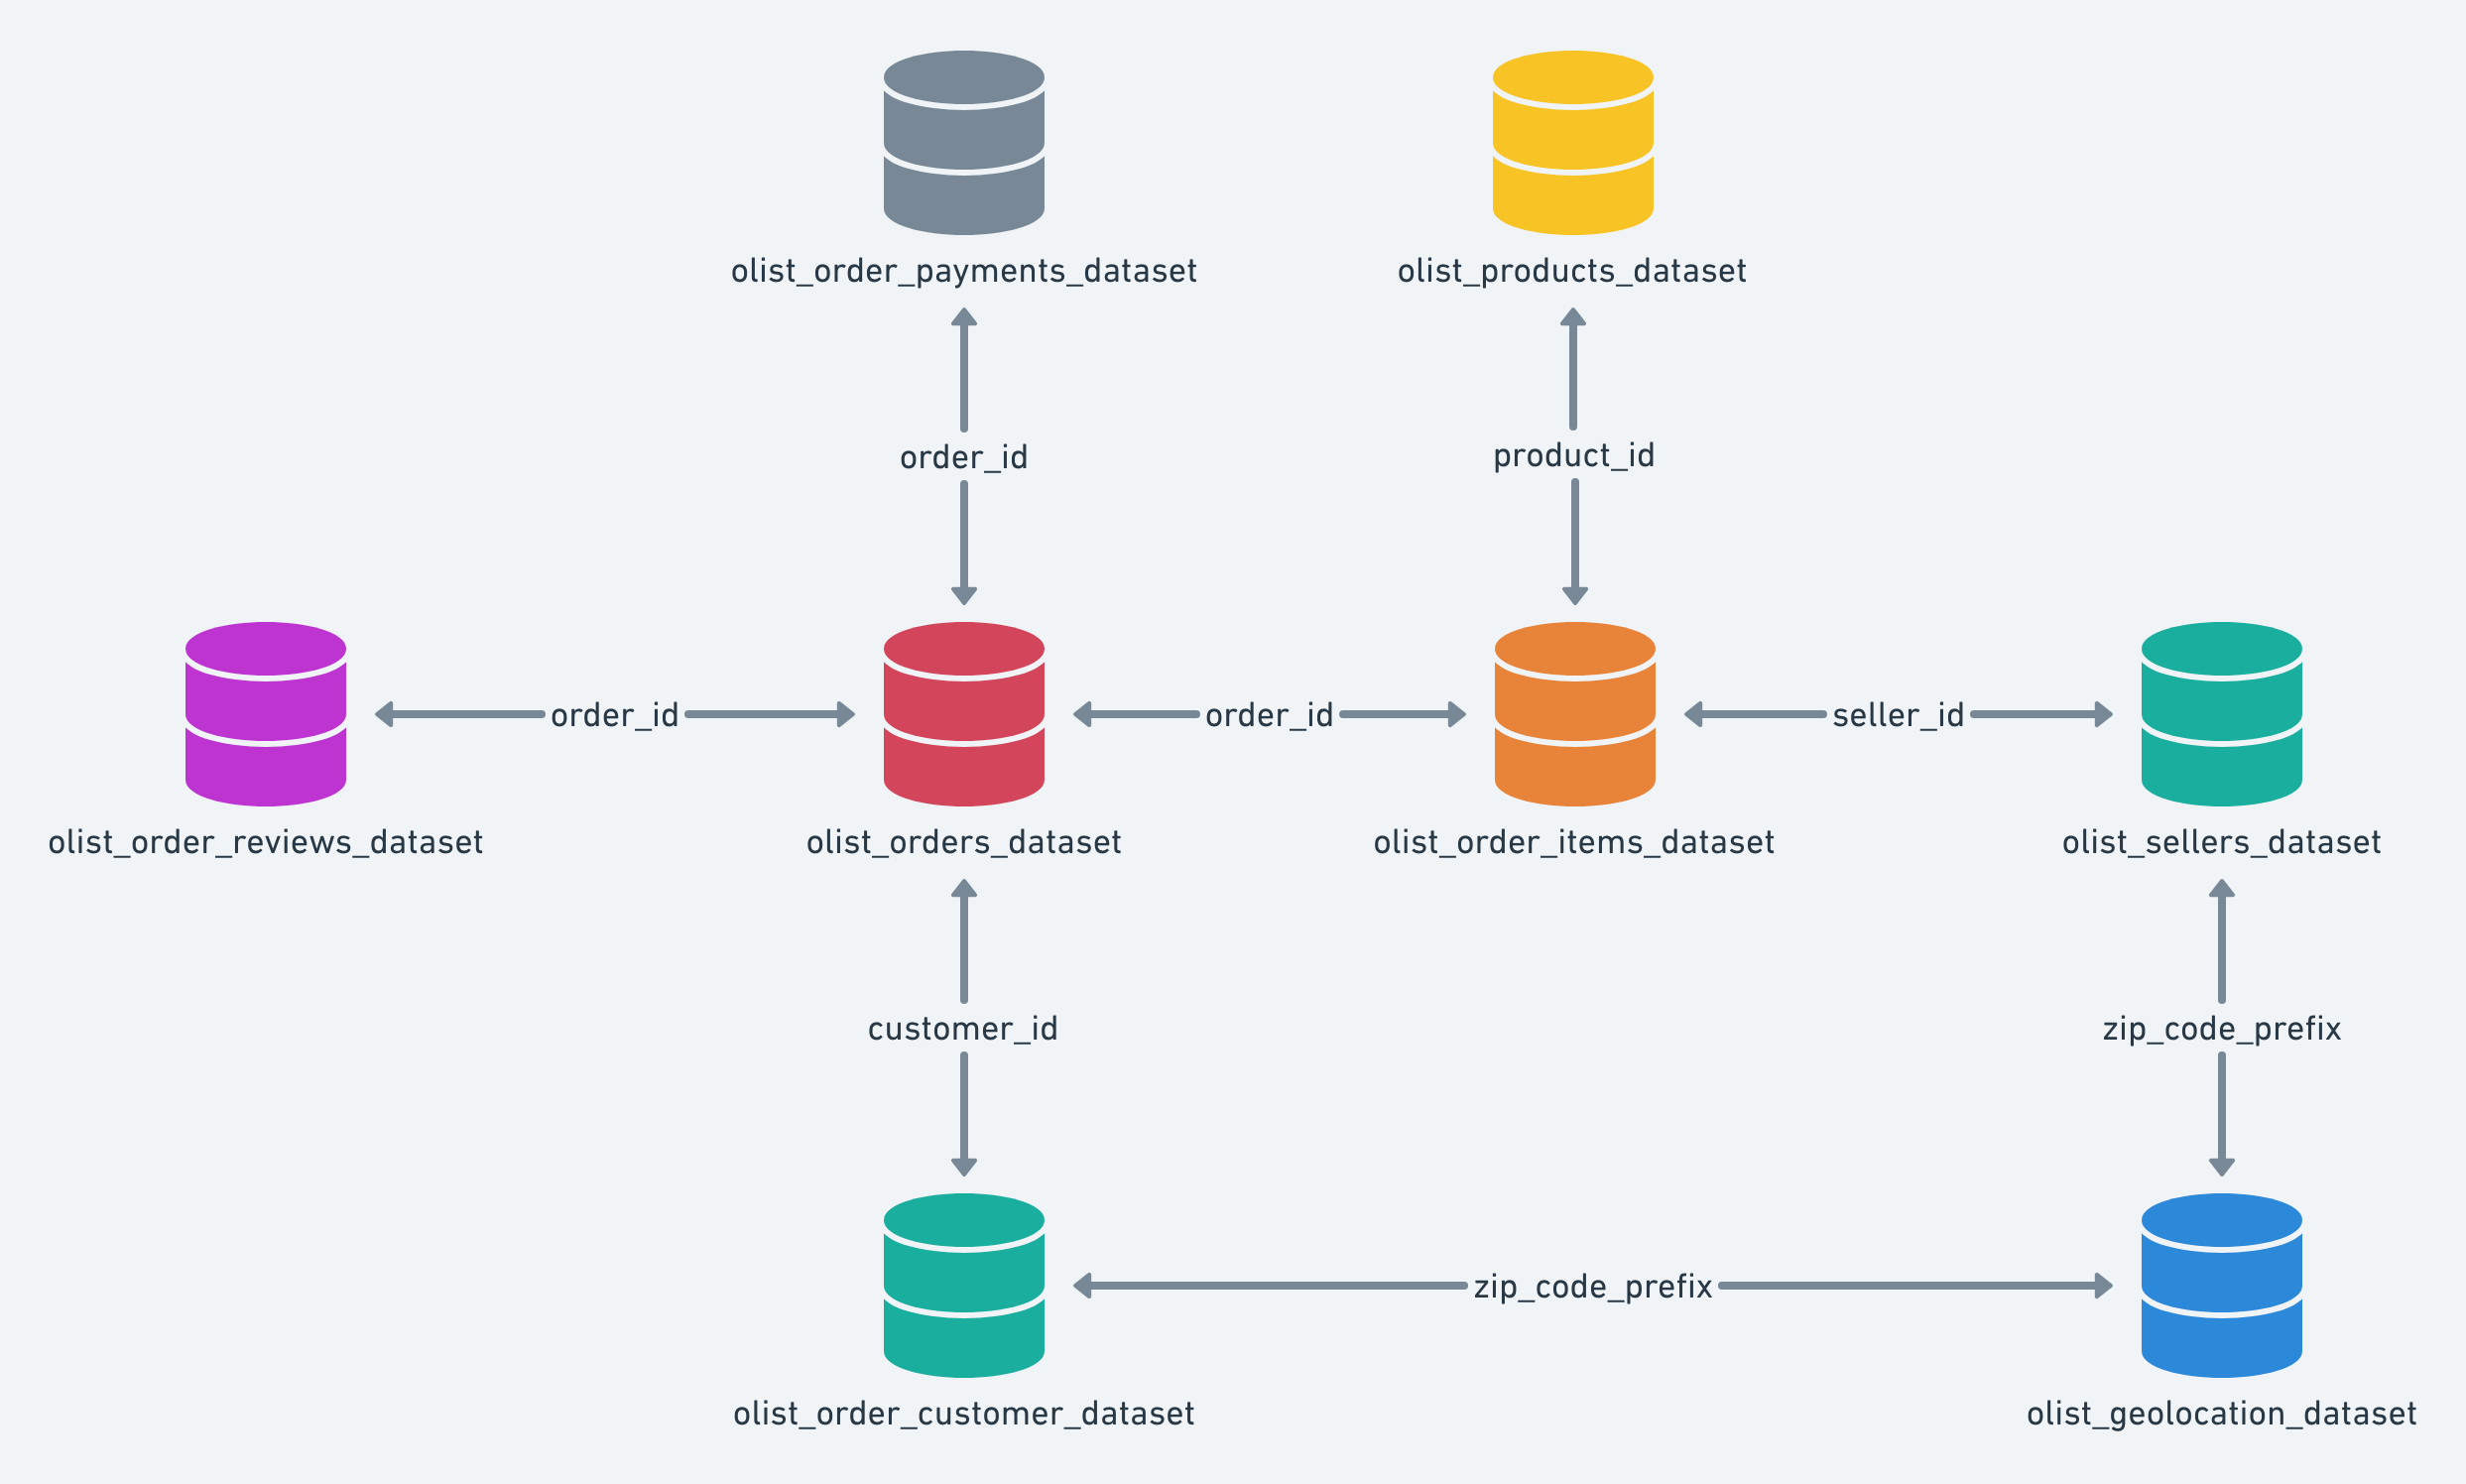

source {fig, datasets} : https://www.kaggle.com/olistbr/brazilian-ecommerce

Kaggle héberge les données et y sont décrits les 8 datasets ainsi qu'un fichier product_category_name_translation. <br/>
Le schéma ci-dessus présente les datasets reliés par les clés indiquées.<br/>

En termes de cardinalités :
- les datasets sont fusionnables simplement avec une cardinalité 1:1 : cas de l'order_id depuis l'orders_dataset, mais également : customer_id, seller_id et product_id,
- un order est composé d'une liste de produits (1:n) via la notion d'items dans le datasets identifiant aussi le seller (1:1).
- un customerunique_id regroupe tous les customer_id associés en 1:1 à un order_id,
- le geolocation_dataset est associé via un zip_code_prefix, soit à un customer, soit à un seller. <br/>

Hors schéma, il reste une association simple des product_category_name en anglais qu'on exploitera pour une meilleure lisibilité.

In [2]:
# importer les packages
# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# specific
from datetime import datetime
import time
# paramètres
sns.set(style="ticks")

In [3]:
# créer les dataframes correspondants aux données
df_customers = pd.read_csv('Data/olist_customers_dataset.csv')
df_orders = pd.read_csv('Data/olist_orders_dataset.csv')
df_items = pd.read_csv('Data/olist_order_items_dataset.csv')
df_products = pd.read_csv('Data/olist_products_dataset.csv')
df_payments = pd.read_csv('Data/olist_order_payments_dataset.csv')
df_sellers = pd.read_csv('Data/olist_sellers_dataset.csv')
df_reviews = pd.read_csv('Data/olist_order_reviews_dataset.csv')
df_geolocation = pd.read_csv('Data/olist_geolocation_dataset.csv')
df_translation = pd.read_csv('Data/product_category_name_translation.csv')

In [4]:
# créer le dict des datasets
datasets = {
    'Orders': df_orders,
    'Items': df_items,
    'Customers': df_customers,
    'Payments': df_payments,
    'Products': df_products,
    'Sellers': df_sellers,
    'Reviews': df_reviews,
    'Geolocation': df_geolocation,
    'Translation': df_translation,
}

In [5]:
# observer les tailles des datasets
for x, y in datasets.items():
    print(f'{x} shape is : ' f'{list(y.shape)}')

Orders shape is : [99441, 8]
Items shape is : [112650, 7]
Customers shape is : [99441, 5]
Payments shape is : [103886, 5]
Products shape is : [32951, 9]
Sellers shape is : [3095, 4]
Reviews shape is : [100000, 7]
Geolocation shape is : [1000163, 5]
Translation shape is : [71, 2]


In [6]:
# fonction d'affichage de la distribution d'un feature

def distribution(df, feature, xlbl):
    plt.figure(figsize=(11, 4))
    x = df.loc[~df[feature].isnull(),
               feature]
    x = np.array(x)
    sns.set(style='whitegrid')
    sns.boxplot(data=x, orient='h')
    plt.title('Distribution of {}'.format(feature))
    plt.xlabel(xlbl)
    plt.yticks([])
    plt.show()



In [7]:
# fonction de split en catégories

def cuts(feature):
    limits = []
    lim_min = feature.min()
    lim_max = feature.max()
    upper_quartile = np.percentile(feature, 75)
    lower_quartile = np.percentile(feature, 25)
    iqr = upper_quartile - lower_quartile
    upper_whisker = feature[feature <= upper_quartile+1.5*iqr].max()
    lower_whisker = feature[feature >= lower_quartile-1.5*iqr].min()
    limits = [lim_min,
              lower_whisker,
              lower_quartile,
              upper_quartile,
              upper_whisker,
              lim_max]
    return(limits)



## 2.1. Revue des données disponibles 
Exploration de chaque dataset

### 2.1.1. Clients
Les données sont anonymisées et sommaires : la localisation {ville, état} reliée à une {lat, lng} via un code, ainsi que le customer_unique_id qui  regroupe tous les customer_id eux-mêmes reliés aux order_id. 

In [8]:
# aperçu des données customers
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
35305,90022669c773334bc88a7f36e5356c5c,50b7c6b058bc386f4a414fa9f63352e1,74565,goiania,GO
33904,32cb7327d17784d2cff0134d28892d72,346055bf530d7571d961f13f03462613,15400,olimpia,SP
73930,437ad6139f698f32fd5301c1bc636e60,36aad42658db613bb6d473de62a16391,29375,venda nova do imigrante,ES


In [9]:
# compter le nombre de clients
df_customers['customer_unique_id'].unique().size

96096

In [10]:
# compter le nb d'achat par client
df_customers_purchase = df_customers.groupby(
    'customer_unique_id',
    as_index=False).agg({'customer_id': ['count']})
df_customers_purchase.columns = ['customer_unique_id',
                                 'order_count']

In [11]:
# afficher les 10 clients ayant effectué le plus de commandes
df_customers_purchase = df_customers_purchase.sort_values(by='order_count',
                                                          ascending=False)
df_customers_purchase[:10]

,customer_unique_id,order_count
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7
7175,12f5d6e1cbf93dafd9dcc19095df0b3d,6
83540,de34b16117594161a6a89c50b289d35a,6
37585,63cfc61cee11cbe306bff5857d00bfe4,6
90451,f0e310a6839dce9de1638e0fe5ab282a,6
27043,47c1a3033b8b77b3ab6e109eb4d5fdf3,6


In [12]:
# moyenne des achats par client
df_customers_purchase['order_count'].mean()

1.0348089410589412

In [13]:
# nombre de clients pour lesquels on détient l'information de 2 achats ou plus
df_customers_purchase[df_customers_purchase['order_count'] > 1].shape

(2997, 2)

In [14]:
# aggréger le nb d'achats effectués pour chaque client unique
df_customers = df_customers.merge(
    df_customers_purchase,
    how='left',
    left_on=['customer_unique_id'],
    right_on=['customer_unique_id'])

In [15]:
# observer le résultat
df_customers.sample(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
36095,887f3d88fcd62b78f2636b8eec812f64,50b3e4affed7bf744d49b2d5946f4f24,38035,uberaba,MG,1
87406,d976b7f96ffd6afe91ee9f725d70ed19,91fd427ee713f3b06b0dc7472ed8ff28,29163,serra,ES,1
36180,c3765d3e438378787581dea1c3dc3d8a,c8deb82e62d0e33c59674b32e8b8be75,22730,rio de janeiro,RJ,1


Cela semble être l'effet d'une troncature des données qui peut compromettre la segmentation : si des commandes ont été retirées pour la majorité des clients on retrouvera logiquement un groupe de clients étant fictivement les seuls à avoir réalisé plusieurs achats. <br/>
A titre d'exemple, l'analyse de l'intervalle entre 2 achats risque de ne pas être représentative au moins quantitativement. <br/>
De même selon la façon de retenir une commnde unique par client (ex. le produit le plus cher qu'il a acheté), celle sélection ajoutera au biais de la troncature des données. <br/>
On retient à ce stade qu'il faudra observer les données de commandes pour un client unique avant de choisir une technique de rationalisation. <br/>

In [16]:
# contrôler les données manquantes
df_customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
order_count                 0
dtype: int64

### 2.1.1. Orders - Commandes
Le processus pour chaque commande est détaillé (order_status et dates associées), à commencer par la date et l'heure d'achat.<br/>
Ces données permettent d'appréhender la période couverte.

In [17]:
# aperçu des données orders
df_orders.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00


In [18]:
# lister les valeurs possibles de l'order_status
df_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Text(0.5, 1.02, 'Order Status')

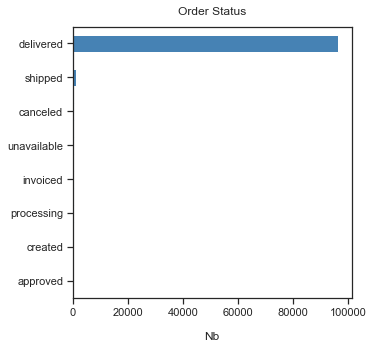

In [19]:
# observer la répartition des commandes par status
df_orders['order_status'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.title('Order Status', y=1.02)

On choisit de retirer les commandes "en cours" et retirer les commandes non disponibles ou annulées - qui font l'objet d'une attention client spécifique.

In [20]:
# retirer les commandes en cours
df_orders = df_orders[df_orders['order_status'] == 'delivered']
print(df_orders.shape)

(96478, 8)


In [21]:
# détecter les valeurs manquantes
df_orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [22]:
# retirer les valeurs manquantes et controler la taille résultante
df_orders = df_orders.dropna().copy()
print(df_orders.shape)

(96455, 8)


In [23]:
# formater les champs dates
for col in ['order_purchase_timestamp',
            'order_approved_at',
            'order_delivered_carrier_date',
            'order_delivered_customer_date',
            'order_estimated_delivery_date']:
    df_orders[col] = pd.to_datetime(df_orders[col],
                                    format='%Y-%m-%d %H:%M:%S')

In [24]:
# décomposer la date d'achat en donnée année, mois, jour, heure
df_orders['order_purchase_year'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.year)
df_orders['order_purchase_month'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.month)
df_orders['order_purchase_day'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df_orders['order_purchase_hour'] =\
    df_orders.order_purchase_timestamp.apply(lambda x: x.hour)
# identifier par son libellé, le moi et le jour de la semaine
df_orders['order_purchase_month_label'] =\
    df_orders.order_purchase_month.map({1: 'Jan',
                                        2: 'Feb',
                                        3: 'Mar',
                                        4: 'Apr',
                                        5: 'May',
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Aug',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'})
df_orders['order_purchase_day_label'] =\
    df_orders.order_purchase_day.map({0: 'Mon',
                                      1: 'Tue',
                                      2: 'Wed',
                                      3: 'Thu',
                                      4: 'Fri',
                                      5: 'Sat',
                                      6: 'Sun'})

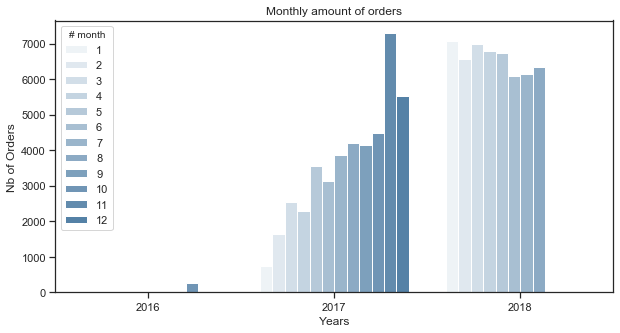

In [25]:
# afficher l'évolution des commandes
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year',
                   hue='order_purchase_month',
                   data=df_orders,
                   color='Steelblue')
ax.set(xlabel='Years',
       ylabel='Nb of Orders',
       title='Monthly amount of orders')
plt.legend(title='# month', loc='upper left')
plt.show()

On observe les retards de livraison :<br/>
Le comportement futur du client peut être affecté par l'écart de date de livraison effective / estimée et dans une moindre mesure par le délai d'approbation de sa commande (ce dernier semble réduit et standard : il ne sera pas considéré à ce stade).<br/>

In [26]:
# calculer l'écart entre la livraison réelle et prévue (en jours d'avance)
df_orders['delivery_vs_estimated'] =\
    (df_orders['order_estimated_delivery_date'] -
     df_orders['order_delivered_customer_date']).dt.days

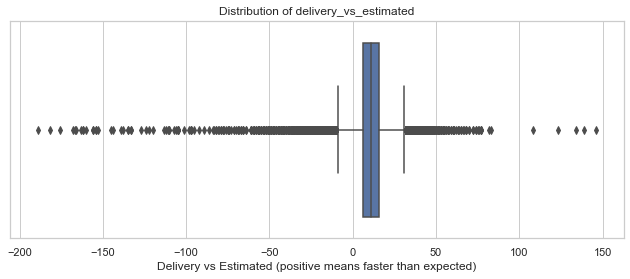

Ecart moyen entre le délai de livraison effective et estimé : 11


In [27]:
# afficher la distribution de l'écart de délai de livraison
distribution(df_orders,
             'delivery_vs_estimated',
             'Delivery vs Estimated (positive means faster than expected)')
print('Ecart moyen entre le délai de livraison effective et estimé : ' +
      str(round(df_orders['delivery_vs_estimated'].mean())))

In [28]:
# déterminer les limites pour catégoriser
cut_bins_delivery_delay = cuts(df_orders['delivery_vs_estimated'])
print(cut_bins_delivery_delay)

[-189, -9, 6.0, 16.0, 31, 146]


In [29]:
# réaliser le découpage en catégories
cut_labels_delivery_delay = ['TooLate_Delivery', 'Late_Delivery', 'OnTime_Delivery', 'Soon_Delivery', 'TooSoon_Delivery']
df_orders['delivery_vs_estimated'] = pd.cut(
    df_orders['delivery_vs_estimated'],
    bins=cut_bins_delivery_delay,
    labels=cut_labels_delivery_delay,
    duplicates='drop')

2:80: E501 line too long (121 > 79 characters)


Text(0.5, 1.02, 'Delivery Delay Levels')

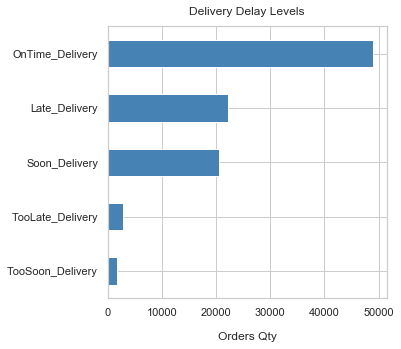

In [30]:
# observer la répartition des retard ou avance de livraison
df_orders['delivery_vs_estimated'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Delivery Delay Levels', y=1.02)

On observe les commandes au cours de la semaine :<br/>
Le comportement passé du client peut être caractérisé par un moment privilégié de la journée, de la semaine ou du mois pour effectuer ses achats.<br/>

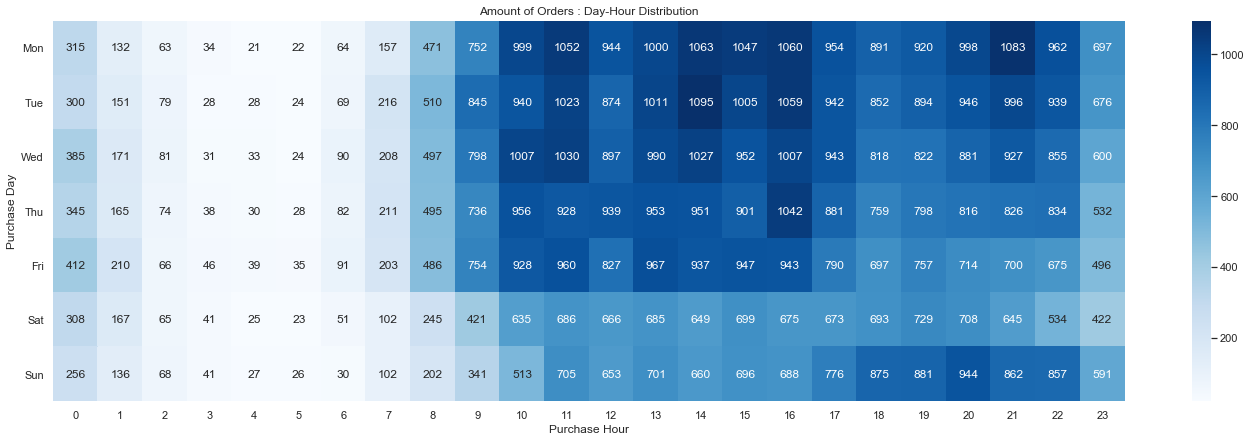

In [31]:
# afficher la répartition des commandes par heure et jour d'achat
order_count = df_orders.groupby(['order_purchase_day',
                                 'order_purchase_hour'])\
    .count()['order_id'].unstack()
plt.figure(figsize=(24, 7))
ax = sns.heatmap(order_count, cmap='Blues', annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set(xlabel='Purchase Hour',
       ylabel='Purchase Day',
       yticklabels=(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']),
       title='Amount of Orders : Day-Hour Distribution')
for item in ax.get_yticklabels():
    item.set_rotation(0)
plt.show()

Du fait des données tronquées, l'association à chaque client via customer_unique_id d'un moment privilégié d'achat, de la date de premier achat (ancienneté), ou de l'intervalle de temps moyen entre 2 commandes risque de ne pas être pleinement représentative.<br/>
Il sera intéressant de raisonner en dépense consentie par le client (prix total du panier, prix du produit le + cher) et non uniquement en nombre de commande (associer aux paiements), idem pour remonter aux caractéristiques de items (catégorie, volume, poids)

### 2.1.2. Articles (Items & Products)

Le dataset items relie la commande (order) aux produits (products) : il détaille le "panier" d'articles commandés, et pour lesquels sont définis le vendeur, le prix, le coût de livraison, une éventuelle date limite d'envoi.<br/>
Tandis que le dataset Products définis les caractéristiques unitaires de catégorie, taille, poids et description de l'article. <br/>
On retrouve la quantité achetée car les produits sont listés unitairement.

### Items

In [32]:
# aperçu des données Items
df_items.sample(7)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
33890,4cb8cb3ecb5dbc9df36cb56451499a0f,1,c9c0435c9331c27dc487a2dc1738a32c,f4db9b37944bcb8873e6b456ee190bbf,2017-09-14 00:03:08,169.99,38.33
19899,2dac1809f9dbdd8fa97870ee26c2736f,1,256711bf66dcd14111581476d6cca1aa,6d66611d7c44cc30ce351abc49a68421,2018-05-25 10:58:31,59.90,19.39
68927,9d6e7e70e068602fa740fc3163cefd3b,1,26ead2db8f3cb1ee3456206dc231f94d,b2bdc5e7940a7d7ca8c4a37953b27a42,2017-12-06 04:15:15,250.00,62.49
36634,532227f6cb279324fdf9b5e3b5e33fbe,1,3d4784f9a07ca5de370c86800589c860,c826c40d7b19f62a09e2d7c5e7295ee2,2018-03-27 13:27:57,97.77,7.55
108886,f7772489190a216873e672f837696a40,1,66e48bcc5ea37a77a5499ced69b7800b,bd0389da23d89b726abf911cccc54596,2018-02-22 22:07:24,28.90,15.79
54182,7b1fa4766801ccecaa2fc8dba3afc30d,1,8bad0b03a701f851b31594eb2eb758b8,7a67c85e85bb2ce8582c35f2203ad736,2017-05-25 12:35:27,20.99,16.60
5422,0c4a1120fa16a1ccbb365aae4f54b16d,2,44a34214a57dc373dcd80f54c919d006,7008613ea464bad5cb9b83456e1e6a8f,2017-10-23 13:56:16,29.50,16.11


In [33]:
# ordonner les articles par prix décroissants
df_items = df_items.sort_values(by=['order_id', 'price'],
                                ascending=False)

In [34]:
# compter le nb d'articles par commande
df_items_count = df_items.groupby(
    'order_id',
    as_index=False).agg({'product_id': ['count']})
df_items_count.columns = ['order_id',
                          'items_qty']

In [35]:
# afficher les 3 commandes avec le plus d'articles
df_items_count = df_items_count.sort_values(by='items_qty',
                                            ascending=False)
df_items_count[:3]

,order_id,items_qty
50137,8272b63d03f5f79c56e9e4120aec44ef,21
10459,1b15974a0141d54e36626dca3fdc731a,20
65715,ab14fdcfbe524636d65ee38360e22ce8,20


In [36]:
# scruter les commandes avec les plus grandes quantité d'articles
df_items[df_items['order_id'] == '8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57317,8272b63d03f5f79c56e9e4120aec44ef,21,79ce45dbc2ea29b22b5a261bbb7b7ee7,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,7.8,6.57
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


Il s'agit de quantités élevées d'un nombre réduit d'articles.

In [37]:
# moyenne du nb d'articles par commande
df_items_count['items_qty'].mean()

1.1417306873695092

In [38]:
# nombre de commandes pour lesquelles il y 2 articles ou plus
df_items_count[df_items_count['items_qty'] > 1].shape

(9803, 2)

In [39]:
# aggréger aux commandes le nb d'articles
df_orders = df_orders.merge(
    df_items_count,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [40]:
df_orders.sample(7)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour,order_purchase_month_label,order_purchase_day_label,delivery_vs_estimated,items_qty
30810,cbd4818fd2df9243a5f4698948f80bd0,1863b95f5438f793f49ba1c6995860e7,delivered,2017-12-07 13:29:50,2017-12-07 15:29:38,2017-12-11 18:21:41,2017-12-14 11:26:54,2018-01-03,2017,12,3,13,Dec,Thu,Soon_Delivery,1
23732,990d8645aca16537246c78b0e24ccf95,970f91cf8d03ab0855cb4b697fe2b6e9,delivered,2018-04-19 13:34:58,2018-04-19 20:11:10,2018-04-20 17:52:00,2018-04-30 11:58:45,2018-05-21,2018,4,3,13,Apr,Thu,Soon_Delivery,2
85412,83329d0539a9b3f087f05db119bee0d6,c8881515a45dd6f97054f6501441e421,delivered,2018-08-14 17:49:36,2018-08-14 18:35:18,2018-08-15 13:55:00,2018-09-11 00:37:34,2018-08-24,2018,8,1,17,Aug,Tue,TooLate_Delivery,1
74810,8007ea147c63f8912e750ada3665086d,b4b518d9d26948512124bf30d3df9c7f,delivered,2018-04-23 10:59:50,2018-04-24 18:42:05,2018-04-24 16:08:34,2018-04-27 18:02:19,2018-05-16,2018,4,0,10,Apr,Mon,Soon_Delivery,1
41580,d631ccd9440f35c118e56f598ebb0261,24e440e12a72cd7915b6353c325e9305,delivered,2018-03-08 18:54:17,2018-03-08 19:10:27,2018-03-09 19:06:24,2018-03-24 16:44:34,2018-03-28,2018,3,3,18,Mar,Thu,Late_Delivery,1
7039,92295e7114a22f7180b04673e44cda17,26d638f7504d7e7fbd443c2dde9dc070,delivered,2018-01-11 21:09:45,2018-01-11 21:19:24,2018-01-13 02:32:50,2018-01-24 16:18:48,2018-02-01,2018,1,3,21,Jan,Thu,OnTime_Delivery,1
13906,671f4219ec92ca6613eb41280aa6ff0d,8fbc0368fd1c18442dd99d4a048ce827,delivered,2017-11-23 16:33:54,2017-11-23 20:49:30,2017-11-24 17:37:06,2017-12-05 22:18:42,2017-12-14,2017,11,3,16,Nov,Thu,OnTime_Delivery,1


In [41]:
# identifier l'article dans la plus grande quantité pour chaque commande
from scipy import stats
df_items_highest_qty = df_items.groupby(
    'order_id',
    as_index=False).agg({'product_id': lambda x: stats.mode(x)[0]})
df_items_highest_qty.columns = ['order_id',
                                'most_ordered_product']

In [42]:
# vérifier un résultat
df_items_highest_qty[df_items_highest_qty['order_id'] == '5a3b1c29a49756e75f1ef513383c0c12']

,order_id,most_ordered_product
34716,5a3b1c29a49756e75f1ef513383c0c12,399f54c06661d06ca45c6e24ed238e0e


In [43]:
# aggréger aux commandes l'article dans la plus grande quantité
df_orders = df_orders.merge(
    df_items_highest_qty,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [44]:
# contrôler le résultat
df_orders.sample(7)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,order_purchase_day,order_purchase_hour,order_purchase_month_label,order_purchase_day_label,delivery_vs_estimated,items_qty,most_ordered_product
52900,d5ea2169e37b50c52923ed4e62482bda,29f12840031180eb478a0c13001b0ca4,delivered,2017-05-29 14:32:09,2017-05-30 04:42:44,2017-06-01 11:55:36,2017-06-02 12:15:18,2017-06-19,2017,5,0,14,May,Mon,OnTime_Delivery,2,2cbd0f06c3123f0bd14c4bffc0498996
75729,354f62589ab0a15eb57e820d6fcbe9b5,ff51b92babcec282546c7ccf5c36adb3,delivered,2017-03-25 21:18:49,2017-03-25 21:25:19,2017-03-27 10:20:04,2017-04-04 12:55:16,2017-04-26,2017,3,5,21,Mar,Sat,Soon_Delivery,2,7e0dc102074f8285580c9777f79c90cf
37208,b6d8afcbedd981f81cd58c1ecf289add,9925762e9ebced24854c787ad2429492,delivered,2017-10-29 17:50:56,2017-10-29 18:55:09,2017-11-01 16:29:29,2017-11-13 17:38:59,2017-11-24,2017,10,6,17,Oct,Sun,OnTime_Delivery,1,8d8fb201f4475a184e799a7f9989cff6
49915,326c5dc4aaf9daba2e0b813c4086156f,4162174e341be4246be9469de35dcce0,delivered,2018-01-14 21:58:40,2018-01-14 22:09:18,2018-01-17 13:24:08,2018-02-03 13:56:41,2018-02-14,2018,1,6,21,Jan,Sun,OnTime_Delivery,1,f95f8434a1ff4885362c44d9d8526579
78361,e409123d7599a3a34c467521576b05fb,444a5cfcdc5e76437c038ec2e42e4ac5,delivered,2018-05-14 09:33:57,2018-05-14 09:55:02,2018-05-15 13:56:00,2018-05-23 18:33:44,2018-06-11,2018,5,0,9,May,Mon,Soon_Delivery,1,06bb6e704f99920f51dbbb0559187d98
30609,1d699c4fd2ee485c965116e9c3fae0b3,b353576acb75a31101c682a70e89e6bd,delivered,2017-08-21 22:04:27,2017-08-21 22:15:08,2017-08-23 13:53:24,2017-08-28 18:45:59,2017-09-14,2017,8,0,22,Aug,Mon,OnTime_Delivery,1,8844bd4b8ca8f93603694ca2bceb77e9
11942,da9f0f35a47f2c08810250876af67d90,deca74811eafebd0f6bf28394e96b935,delivered,2017-04-06 21:40:58,2017-04-06 21:50:22,2017-04-10 16:32:03,2017-04-18 12:21:27,2017-05-03,2017,4,3,21,Apr,Thu,OnTime_Delivery,1,db6612711588e8be758dc6cb66d031d2


Le coût de livraison semble s'ajouter pour chaque produit contrairement à ce qu'on imagine dans la réalité. <br/>
On construit : 
- une indication de la valeur de coût de livraison par rapport au coût des produits d'une commande. <br/>
- une indication du type de prix affiché avec terminaison "9", dit "charm price".

In [45]:
# scruter les commandes sans frais de livraison
df_items[df_items['freight_value'] == 0].shape

(383, 7)

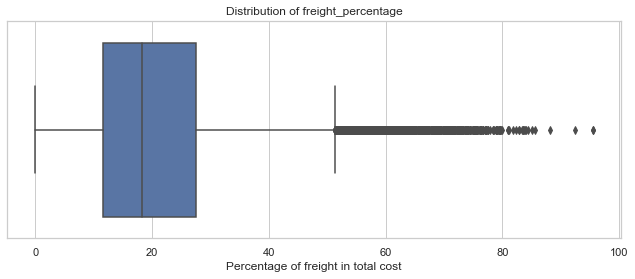

Pourcentage moyen du coût de livraison : 20


In [46]:
# calculer les coûts totaux produits et livraison
# à renommer en cart_costs
df_items_costs = df_items.groupby(
    'order_id',
    as_index=False).agg({'price': ['sum'],
                         'freight_value': ['sum']})
df_items_costs.columns = ['order_id',
                          'total_price',
                          'total_freight']
# déterminer la proportion du coût de livraison
df_items_costs['freight_percentage'] = \
    100 * df_items_costs['total_freight'] / \
    (df_items_costs['total_freight'] + df_items_costs['total_price'])
# afficher la distribution de la proportion du coût de livraison
distribution(df_items_costs,
             'freight_percentage',
             'Percentage of freight in total cost')
print('Pourcentage moyen du coût de livraison : %d'
      % df_items_costs['freight_percentage'].mean())

In [47]:
# déterminer les limites pour catégoriser
cut_bins_freight_level = cuts(df_items_costs['freight_percentage'])
print(cut_bins_freight_level)

[0.0, 0.0, 11.650194669062593, 27.54625320472594, 51.390239160023334, 95.54507337526205]


In [48]:
# réaliser le découpage en niveau de coût de livraison
cut_labels_freight_level = ['BelowMed_FreightCost',
                            'AroundMed_FreightCost',
                            'OverMed_FreightCost',
                            'TooHigh_FreightCost']
df_items_costs['freight_level'] = pd.cut(
    df_items_costs['freight_percentage'],
    bins=cut_bins_freight_level,
    labels=cut_labels_freight_level,
    duplicates='drop')

Text(0.5, 1.02, 'Freight Levels')

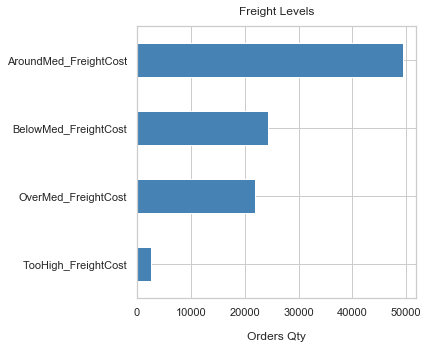

In [49]:
# observer la répartition des commandes par status
df_items_costs['freight_level'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Freight Levels', y=1.02)

In [50]:
# Observer les 4 features créés
df_items_costs

,order_id,total_price,total_freight,freight_percentage,freight_level
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29,18.409752,AroundMed_FreightCost
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93,7.670400,BelowMed_FreightCost
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87,8.239959,BelowMed_FreightCost
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79,49.612102,OverMed_FreightCost
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14,8.319574,BelowMed_FreightCost
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41,12.641235,AroundMed_FreightCost
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53,9.450754,BelowMed_FreightCost
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95,14.505777,AroundMed_FreightCost
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72,13.475506,AroundMed_FreightCost


In [51]:
# aggréger aux commandes le niveau de coût de livraison
df_orders = df_orders.merge(
    df_items_costs,
    how='left',
    left_on=['order_id'],
    right_on=['order_id'])

In [52]:
# contrôler le résultat
df_orders.sample(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_year,order_purchase_month,...,order_purchase_hour,order_purchase_month_label,order_purchase_day_label,delivery_vs_estimated,items_qty,most_ordered_product,total_price,total_freight,freight_percentage,freight_level
65561,9874f00b86dad32c32a0017e80cfcdb4,8ee173c92d41d059bae3732ee2d4a422,delivered,2017-03-09 01:36:39,2017-03-09 01:36:39,2017-03-10 10:48:01,2017-03-14 13:05:37,2017-04-06,2017,3,...,1,Mar,Thu,Soon_Delivery,1,33b0f8037510c23d243bb510d7d6e07d,69.90,15.70,18.341121,AroundMed_FreightCost
20104,7d2ce95144e1dac8886fa0b3d498baf2,716fd5f79daef847a1b093ec2be493f1,delivered,2018-02-13 20:16:06,2018-02-13 20:25:26,2018-02-15 22:42:50,2018-02-16 22:08:10,2018-02-26,2018,2,...,20,Feb,Tue,OnTime_Delivery,1,0ea04fc101523a27bb53845d14d7d809,18.00,8.27,31.480777,OverMed_FreightCost
43865,3398f00480d402f9b8522e6bda2c29d5,251f5f0058f31c30526c210905587660,delivered,2017-10-22 20:23:26,2017-10-22 20:35:23,2017-10-24 23:03:56,2017-10-31 20:33:47,2017-11-21,2017,10,...,20,Oct,Sun,Soon_Delivery,1,4c2394abfbac7ff59ec7a420918562fa,84.99,15.35,15.297987,AroundMed_FreightCost


In [53]:
# isoler la terminaison 9 des prix affiché, dit "charm price"
# isoler les terminaisons (Centavos, Real)
df_items['last_centavos'] = df_items['price'] % 1
df_items['last_real'] = df_items['price'] % 10 - df_items['price'] % 1
# convertir en info booléen "is_charm"
df_items['charm_centavos'] =\
    df_items['last_centavos'].map(
    lambda x: 0 if x < 0.88 else 1)
df_items['charm_real'] =\
    df_items['last_real'].map(
    lambda x: 0 if x != 9 else 1)
# déterminer un booléen "charm_price" si l'une des terminaisons est "charm"
df_items['charm_price'] = df_items['charm_real'] + df_items['charm_centavos']
df_items['charm_price'] =\
    df_items['charm_price'].map(
    lambda x: 1 if x >= 1 else 0)
# retirer les colonnes obsolètes
Drop = ['last_centavos',
        'last_real',
        'charm_centavos',
        'charm_real']
df_items.drop(Drop, axis=1, inplace=True)

In [54]:
# observer le résultat
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,charm_price
43410,62b22cf8987a8a48d638c4bcaf7024ce,2,b62a475bcfd309c66d84a1a93aa75fd8,b499c00f28f4b7069ff6550af8c1348a,2018-07-04 11:50:29,44.99,9.19,1
59997,88af1e29bb0ae20c379da31875a94806,1,b69eb25e3a4def8e9cddee18712e0c5e,8ed8ea9a57c862f2c18c2fe41f601d56,2018-05-16 15:35:25,199.00,32.79,1
101961,e760cfb29c60e22956a48ad4c4e6a639,1,0705b33fb285827a578fce4899f1b921,318f287a62ab7ac10b703ac37435a231,2017-07-24 05:55:16,22.50,9.34,0


### Products

In [55]:
# aperçu des données Products
print(df_products.shape)
df_products.head(3)

(32951, 9)


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0


In [56]:
# retirer les valeurs manquantes et controler la taille résultante
df_products = df_products.dropna().copy()
print(df_products.shape)

(32340, 9)


In [57]:
# renommer les colonnes lenght -> length
df_products = df_products.rename(columns={
    'product_name_lenght': 'product_name_length',
    'product_description_lenght': 'product_description_length'})

In [58]:
# simplifier la taille des produits (volume)
df_products['product_size'] = df_products['product_length_cm'] * \
    df_products['product_height_cm'] * df_products['product_width_cm']
# ne garder que cette nouvelle caractéristique
df_products = df_products.drop(
    columns=['product_length_cm',
             'product_height_cm',
             'product_width_cm'])

In [59]:
# observer les valeurs numériques
df_products.describe()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size
count,32340.000000,32340.000000,32340.000000,32340.000000,32340.000000
mean,48.476592,771.492393,2.188961,2276.956586,16577.961286
std,10.245699,635.124831,1.736787,4279.291845,27062.978147
min,5.000000,4.000000,1.000000,0.000000,168.000000
25%,42.000000,339.000000,1.000000,300.000000,2880.000000
50%,51.000000,595.000000,1.000000,700.000000,6860.000000
75%,57.000000,972.000000,3.000000,1900.000000,18522.750000
max,76.000000,3992.000000,20.000000,40425.000000,296208.000000


In [60]:
# compter les valeurs manquantes
df_products.isna().sum()

product_id                    0
product_category_name         0
product_name_length           0
product_description_length    0
product_photos_qty            0
product_weight_g              0
product_size                  0
dtype: int64

In [61]:
# retirer les valeurs manquantes
df_products = df_products.dropna().copy()

#### Catégoriser les produits par qualité de description : taille de description, de nom, nombre de photos

#### Product Description Length

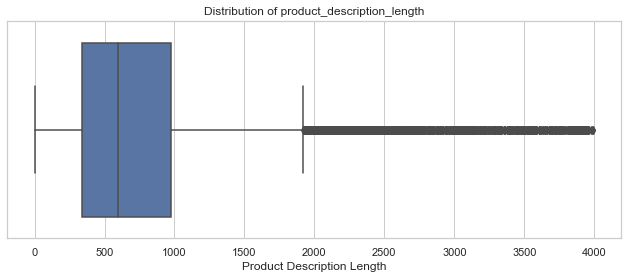

Taille moyenne de la description produit : 771


In [62]:
# observer le product_description_length
distribution(df_products,
             'product_description_length',
             'Product Description Length')
print('Taille moyenne de la description produit : %d'
      % df_products['product_description_length'].mean())

In [63]:
# définir les limites des niveaux de taille de description
cut_bins_desc_length = cuts(df_products['product_description_length'])
print(cut_bins_desc_length)

[4.0, 4.0, 339.0, 972.0, 1920.0, 3992.0]


In [64]:
# réaliser la catégorisation par taille de description
cut_labels_desc_length = ['BelowMed_DescLength',
                          'AroundMed_DescLength',
                          'OverMed_DescLength',
                          'TooHigh_DescLength']
df_products['product_description_length'] = pd.cut(
    df_products['product_description_length'],
    bins=cut_bins_desc_length,
    labels=cut_labels_desc_length,
    duplicates='drop')

Text(0.5, 1.02, 'Product Description Length Levels')

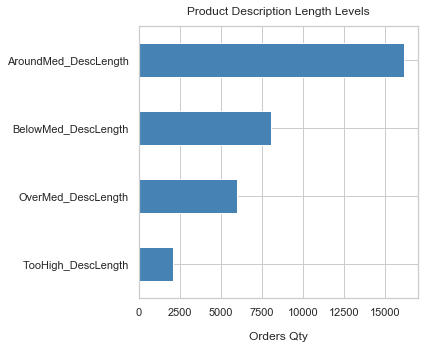

In [65]:
# observer la répartition des niveaux de taille de description
df_products['product_description_length'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Description Length Levels', y=1.02)

#### Product Name Length

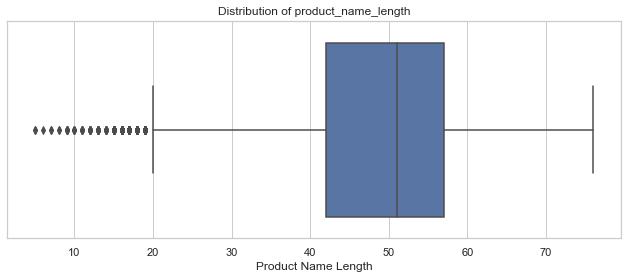

Taille moyenne nom du produit : 48


In [66]:
# observer le taille du nom de produit
distribution(df_products,
             'product_name_length',
             'Product Name Length')
print('Taille moyenne nom du produit : %d'
      % df_products['product_name_length'].mean())

In [67]:
# définir les limites des niveaux de taille de nom
cut_bins_name_length = cuts(df_products['product_name_length'])
print(cut_bins_name_length)

[5.0, 20.0, 42.0, 57.0, 76.0, 76.0]


In [68]:
# réaliser la catégorisation par taille de nom
cut_labels_name_length = ['TooShort_NameLength',
                          'BelowMed_NameLength',
                          'AroundMed_NameLength',
                          'OverMed_NameLength']
df_products['product_name_length'] = pd.cut(
    df_products['product_name_length'],
    bins=cut_bins_name_length,
    labels=cut_labels_name_length,
    duplicates='drop')

Text(0.5, 1.02, 'Product Name Length Levels')

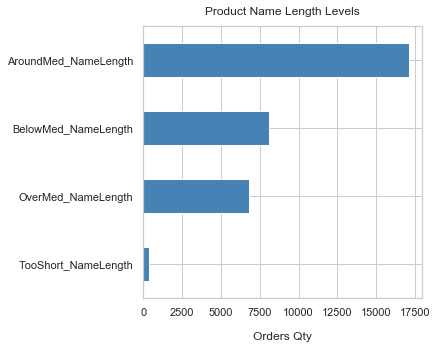

In [69]:
# observer la répartition des niveaux de taille de nome
df_products['product_name_length'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Name Length Levels', y=1.02)

#### Photo Quantity

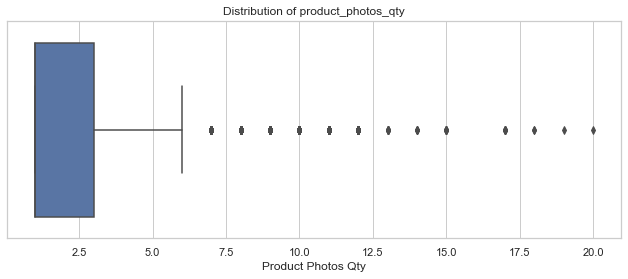

Nb moyen de photos disponibles : 2


In [70]:
# observer le product_photos_qty
distribution(df_products,
             'product_photos_qty',
             'Product Photos Qty')
print('Nb moyen de photos disponibles : %d'
      % df_products['product_photos_qty'].mean())

In [71]:
# définir les limites des niveaux de photos disponibles
cut_bins_photo_qty = cuts(df_products['product_photos_qty'])
print(cut_bins_photo_qty)

[1.0, 1.0, 1.0, 3.0, 6.0, 20.0]


In [72]:
# réaliser la catégorisation par taille de description
cut_labels_photo_qty = ['AroundMed_PhotoQty',
                        'OverMed_PhotoQty',
                        'TooHigh_PhotoQty']
df_products['product_photos_qty'] = pd.cut(
    df_products['product_photos_qty'],
    bins=cut_bins_photo_qty,
    labels=cut_labels_photo_qty,
    duplicates='drop')

Text(0.5, 1.02, 'Photos Qty Levels')

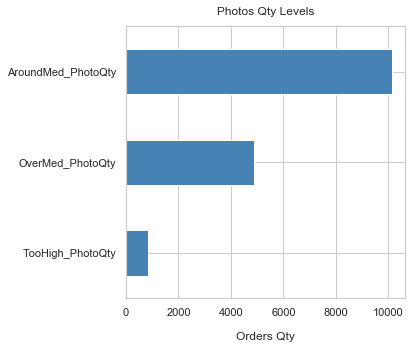

In [73]:
# observer la répartition des niveaux de taille de description
df_products['product_photos_qty'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Photos Qty Levels', y=1.02)

#### Catégoriser les produits par caractéristique taille et poids

#### Taille

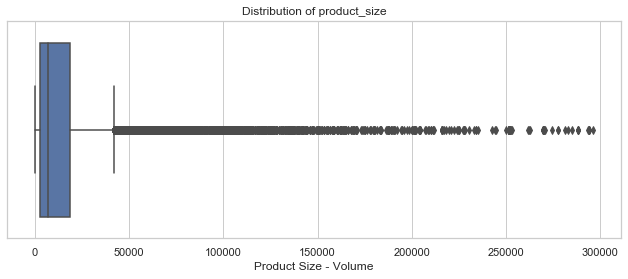

Taille moyenne des produits : 16577


In [74]:
# observer le product_size
distribution(df_products,
             'product_size',
             'Product Size - Volume')
print('Taille moyenne des produits : %d'
      % df_products['product_size'].mean())

In [75]:
# définir les limites des niveaux de photos disponibles
cut_bins_prod_size = cuts(df_products['product_size'])
print(cut_bins_prod_size)

[168.0, 168.0, 2880.0, 18522.75, 41976.0, 296208.0]


In [76]:
# réaliser la catégorisation par taille de description
cut_labels_prod_size = ['Small_Size',
                        'AroundMed_Size',
                        'Big_Size',
                        'OverLarge_Size']
df_products['product_size'] = pd.cut(
    df_products['product_size'],
    bins=cut_bins_prod_size,
    labels=cut_labels_prod_size,
    duplicates='drop')

Text(0.5, 1.02, 'Product Size Levels')

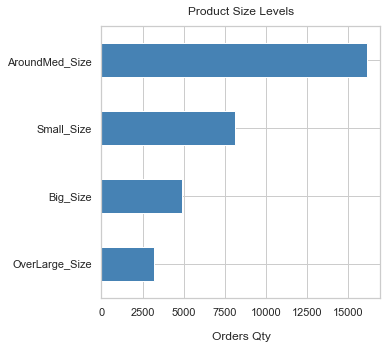

In [77]:
# observer la répartition des niveaux de taille de description
df_products['product_size'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Product Size Levels', y=1.02)

#### Poids

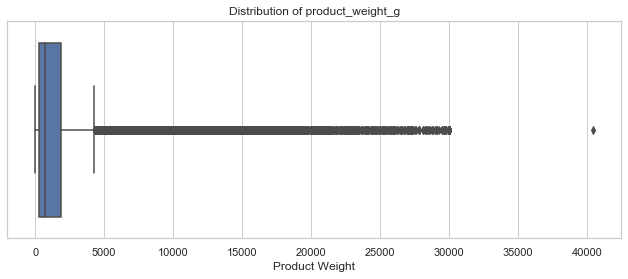

Poids moyen des produits : 2276


In [78]:
# observer le poids
distribution(df_products,
             'product_weight_g',
             'Product Weight')
print('Poids moyen des produits : %d'
      % df_products['product_weight_g'].mean())

In [79]:
# définir les limites des niveaux de photos disponibles
cut_bins_prod_weight = cuts(df_products['product_weight_g'])
print(cut_bins_prod_weight)

[0.0, 0.0, 300.0, 1900.0, 4300.0, 40425.0]


In [80]:
# réaliser la catégorisation par taille de description
cut_labels_prod_weight = ['Light_Weight',
                          'ArounMed_Weight',
                          'Heavy_Weight',
                          'Massive_Weight']
df_products['product_weight_g'] = pd.cut(
    df_products['product_weight_g'],
    bins=cut_bins_prod_weight,
    labels=cut_labels_prod_weight,
    duplicates='drop')

Text(0.5, 1.02, 'Products Weight Levels')

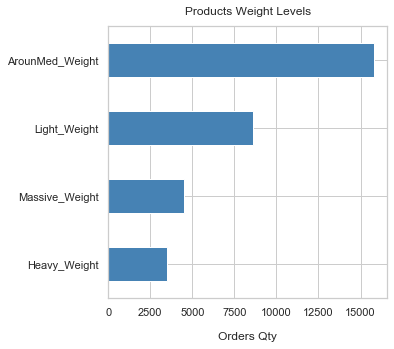

In [81]:
# observer la répartition des niveaux de taille de description
df_products['product_weight_g'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(5, 5)).invert_yaxis()
plt.xlabel('Orders Qty', labelpad=14)
plt.title('Products Weight Levels', y=1.02)

In [82]:
# contrôler le résulat
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size
13441,f567d4c09e85e4faf20f896b363fb827,esporte_lazer,AroundMed_NameLength,TooHigh_DescLength,NaN,Light_Weight,Small_Size
30010,cc1b0e67ffb98a08c886e8c3c27a915f,papelaria,OverMed_NameLength,BelowMed_DescLength,OverMed_PhotoQty,ArounMed_Weight,Big_Size
3970,6d1befe53a3d28e0d0d8b3bfcce11195,automotivo,AroundMed_NameLength,OverMed_DescLength,NaN,ArounMed_Weight,Big_Size


#### Catégories des produits

In [83]:
# exploiter la version anglaise des catégories
df_translation.sample(3)

,product_category_name,product_category_name_english
36,construcao_ferramentas_ferramentas,costruction_tools_tools
7,utilidades_domesticas,housewares
1,informatica_acessorios,computers_accessories


In [84]:
# améliorer la lisibilité des product category
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.replace('_', ' ')
df_translation['product_category_name_english'] =\
    df_translation['product_category_name_english'].str.title()

In [85]:
# aggréger aux produits la version anglaise des catégories
df_products = df_products.merge(
    df_translation,
    how='left',
    left_on=['product_category_name'],
    right_on=['product_category_name'])
df_products.sample(3)

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_category_name_english
9752,16c1c1a3dc1ddc2fd5e32ae7fe616b0b,cama_mesa_banho,AroundMed_NameLength,BelowMed_DescLength,NaN,Heavy_Weight,AroundMed_Size,Bed Bath Table
23407,53bd0c908c6ab820c9828763348728ef,moveis_decoracao,OverMed_NameLength,BelowMed_DescLength,NaN,ArounMed_Weight,AroundMed_Size,Furniture Decor
3560,914cb9a32dcc2be329cd84c5012edc5d,moveis_quarto,BelowMed_NameLength,AroundMed_DescLength,AroundMed_PhotoQty,ArounMed_Weight,AroundMed_Size,Furniture Bedroom


In [86]:
# décompter et lister les catégories
print(df_products['product_category_name_english'].unique().size)
df_products['product_category_name_english'].unique()

72


array(['Perfumery', 'Art', 'Sports Leisure', 'Baby', 'Housewares',
       'Musical Instruments', 'Cool Stuff', 'Furniture Decor',
       'Home Appliances', 'Toys', 'Bed Bath Table',
       'Construction Tools Safety', 'Computers Accessories',
       'Health Beauty', 'Luggage Accessories', 'Garden Tools',
       'Office Furniture', 'Auto', 'Electronics', 'Fashion Shoes',
       'Telephony', 'Stationery', 'Fashion Bags Accessories', 'Computers',
       'Home Construction', 'Watches Gifts',
       'Construction Tools Construction', 'Pet Shop', 'Small Appliances',
       'Agro Industry And Commerce', 'Furniture Living Room',
       'Signaling And Security', 'Air Conditioning', 'Consoles Games',
       'Books General Interest', 'Costruction Tools Tools',
       'Fashion Underwear Beach', 'Fashion Male Clothing',
       'Kitchen Dining Laundry Garden Furniture',
       'Industry Commerce And Business', 'Fixed Telephony',
       'Construction Tools Lights', 'Books Technical',
       'Home App

In [87]:
# denombrer les produits non catégorisés inconnues
df_products['product_category_name_english'].isna().sum()

13

In [88]:
df_products.isna().sum()

product_id                           0
product_category_name                0
product_name_length                  2
product_description_length           5
product_photos_qty               16489
product_weight_g                     4
product_size                         1
product_category_name_english       13
dtype: int64

In [89]:
df_products = df_products[df_products['product_category_name_english'] != 'NaN']

In [90]:
# calculer la quantité de produits dans chaque catégorie
rows = [[i, df_products[df_products['product_category_name_english'] ==
                        i].shape[0]]
        for i in df_products['product_category_name_english'].unique()]
df_category_qty = pd.DataFrame(rows, columns=['category', 'qty'])
# trier par nb de produits décroissant
df_category_qty = df_category_qty.sort_values(by='qty',
                                              ascending=False)

In [91]:
# lister les catégorie par nb de produits
pd.set_option('display.max_rows', df_category_qty.shape[0]+1)
df_category_qty

,category,qty
10,Bed Bath Table,3029
2,Sports Leisure,2867
7,Furniture Decor,2657
13,Health Beauty,2444
4,Housewares,2335
17,Auto,1900
12,Computers Accessories,1639
9,Toys,1411
25,Watches Gifts,1329
20,Telephony,1134


In [92]:
# aggreger aux items les produits
df_items = df_items.merge(
    df_products,
    how='left',
    left_on=['product_id'],
    right_on=['product_id'])
df_items.sample(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,charm_price,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_category_name_english
110307,0551ab30e952cbf19e26f0f6baab13a6,2,a6883f92891e256b926bf8b9c40fbe9f,f5f1f2c5f923f36ad79ea1d07185ddc9,2018-03-29 13:47:25,149.00,18.90,1,pet_shop,BelowMed_NameLength,AroundMed_DescLength,NaN,Light_Weight,Small_Size,Pet Shop
73860,5825f62edda362144cd0c349124fa927,1,6767719f80aabbbf16ab2491899c32d9,c4d51195486dc781531876a7d00453d8,2018-05-17 21:31:45,839.99,18.32,1,telefonia,AroundMed_NameLength,TooHigh_DescLength,AroundMed_PhotoQty,ArounMed_Weight,Small_Size,Telephony
63705,6f2ed4a14ddb4db99255cbb30951ab59,1,1a079ba5d672d64c3bdae859c45d8e67,85d9eb9ddc5d00ca9336a2219c97bb13,2018-03-06 21:10:19,38.90,14.10,1,informatica_acessorios,BelowMed_NameLength,OverMed_DescLength,AroundMed_PhotoQty,Light_Weight,Small_Size,Computers Accessories


In [93]:
# décompter les produits commandés par catégorie
df_categ_qty = df_items.groupby('product_category_name_english',
                                as_index=False).agg({'order_id': ['count']})
df_categ_qty.columns = ['product_category_name_english',
                        'count']
df_categ_qty = df_categ_qty.sort_values(by='count',
                                        ascending=False)

In [94]:
pd.set_option('display.max_rows', df_category_qty.shape[0]+1)
df_categ_qty

,product_category_name_english,count
7,Bed Bath Table,11115
43,Health Beauty,9670
65,Sports Leisure,8641
39,Furniture Decor,8334
15,Computers Accessories,7827
49,Housewares,6964
70,Watches Gifts,5991
68,Telephony,4545
42,Garden Tools,4347
5,Auto,4235


In [95]:
# aggreger les décompte de produits et produits commandés
df_category_qty = df_category_qty.merge(
    df_categ_qty,
    how='left',
    left_on=['category'],
    right_on=['product_category_name_english'])
df_category_qty = df_category_qty.sort_values(by='count',
                                              ascending=False)

In [96]:
df_category_qty

,category,qty,product_category_name_english,count
0,Bed Bath Table,3029,Bed Bath Table,11115.0
3,Health Beauty,2444,Health Beauty,9670.0
1,Sports Leisure,2867,Sports Leisure,8641.0
2,Furniture Decor,2657,Furniture Decor,8334.0
6,Computers Accessories,1639,Computers Accessories,7827.0
4,Housewares,2335,Housewares,6964.0
8,Watches Gifts,1329,Watches Gifts,5991.0
9,Telephony,1134,Telephony,4545.0
15,Garden Tools,753,Garden Tools,4347.0
5,Auto,1900,Auto,4235.0


L'ordre des quantités de produits par catégories est similaire à l'ordre des quantités de commandes effectuées dans ces catégories 

In [97]:
# rationaliser les catégories
category_mapping = {
    'Food': 'Food Drink',
    'Drinks': 'Food Drink',
    'Flowers': 'Food Drink',
    'Perfumery': 'Health Beauty',
    'Baby': 'Health Beauty',
    'Diapers And Hygiene': 'Health Beauty',
    'Bed Bath Table': 'Home Accessories',
    'Home Confort': 'Home Accessories',
    'Home Comfort 2': 'Home Accessories',
    'La Cuisine': 'Home Accessories',
    'Housewares': 'Home Appliances',
    'Small Appliances': 'Home Appliances',
    'Home Appliances 2': 'Home Appliances',
    'Small Appliances Home Oven And Coffee': 'Home Appliances',
    'Air Conditioning': 'Home Appliances',
    'Art': 'Culture',
    'Cine Photo': 'Culture',
    'Books General Interest': 'Culture',
    'Cds Dvds Musicals': 'Culture',
    'Music': 'Culture',
    'Books Technical': 'Culture',
    'Audio': 'Culture',
    'Dvds Blu Ray': 'Culture',
    'Books Imported': 'Culture',
    'Arts And Craftmanship': 'Culture',
    'Musical Instruments': 'Culture',
    'Fashion Male Clothing': 'Fashion',
    'Fashion Sport': 'Fashion',
    'Fashion Underwear Beach': 'Fashion',
    'Fashion Bags Accessories': 'Fashion',
    'Fashio Female Clothing': 'Fashion',
    'Fashion Shoes': 'Fashion',
    'Fashion Childrens Clothes': 'Fashion',
    'Luggage Accessories': 'Fashion',
    'Kitchen Dining Laundry Garden Furniture': 'Furniture',
    'Furniture Decor': 'Furniture',
    'Office Furniture': 'Furniture',
    'Furniture Living Room': 'Furniture',
    'Furniture Bedroom': 'Furniture',
    'Furniture Mattress And Upholstery': 'Furniture',
    'Costruction Tools Tools': 'Construction & Tools',
    'Construction Tools Safety': 'Construction & Tools',
    'Garden Tools': 'Construction & Tools',
    'Construction Tools Lights': 'Construction & Tools',
    'Construction Tools Construction': 'Construction & Tools',
    'Costruction Tools Garden': 'Construction & Tools',
    'Home Construction': 'Construction & Tools',
    'Computers Accessories': 'Computers & Accessories',
    'Computers': 'Computers & Accessories',
    'Fixed Telephony': 'Telephony',
    'Tablets Printing Image': 'Computers & Accessories',
    'Agro Industry And Commerce': 'Corporate',
    'Signaling And Security': 'Corporate',
    'Security And Services': 'Corporate',
    'Industry Commerce And Business': 'Corporate',
    'Market Place': 'Corporate',
    'Stationery': 'Supplies',
    'Cool Stuff': 'Supplies',
    'Party Supplies': 'Supplies',
    'Christmas Supplies': 'Supplies'}

In [98]:
df_category_qty = df_category_qty.rename(columns={'product_category_name_english': 'Rational_Category'})

In [99]:
df_category_qty['Rational_Category'] = df_category_qty['Rational_Category'].replace(category_mapping)

In [100]:
df_category_qty

,category,qty,Rational_Category,count
0,Bed Bath Table,3029,Home Accessories,11115.0
3,Health Beauty,2444,Health Beauty,9670.0
1,Sports Leisure,2867,Sports Leisure,8641.0
2,Furniture Decor,2657,Furniture,8334.0
6,Computers Accessories,1639,Computers & Accessories,7827.0
4,Housewares,2335,Home Appliances,6964.0
8,Watches Gifts,1329,Watches Gifts,5991.0
9,Telephony,1134,Telephony,4545.0
15,Garden Tools,753,Construction & Tools,4347.0
5,Auto,1900,Auto,4235.0


In [101]:
# décompter les produits commandés par rational_category
df_rat_categ_qty = df_category_qty.groupby(
    'Rational_Category',
    as_index=False).agg({'count': ['sum']})
df_rat_categ_qty.columns = ['Rational_Category',
                            'new_count']
df_rat_categ_qty = df_rat_categ_qty.sort_values(by='new_count',
                                                ascending=False)

In [102]:
df_rat_categ_qty

,Rational_Category,new_count
10,Health Beauty,16192.0
11,Home Accessories,11593.0
9,Furniture,10956.0
12,Home Appliances,9025.0
14,Sports Leisure,8641.0
1,Computers & Accessories,8113.0
3,Construction & Tools,6719.0
15,Supplies,6509.0
18,Watches Gifts,5991.0
16,Telephony,4809.0


In [103]:
df_products[df_products['product_id'] == '05b515fdc76e888aada3c6d66c201dff']

,product_id,product_category_name,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_size,product_category_name_english
15910,05b515fdc76e888aada3c6d66c201dff,beleza_saude,AroundMed_NameLength,BelowMed_DescLength,AroundMed_PhotoQty,ArounMed_Weight,Small_Size,Health Beauty


### 2.1.3. Données géographiques

Geolocation détaille toutes les paires {lat, lng}, associée à un zip_code_prefix, avec toute une diversité pour chaque {city, state}.
Pour conserver une exploitabilité et une signification marketing (zone géographiques, distances, etc.) on propose de préserver une donnée de localisation simple {lat mean, lng mean} qui sera associé à chaque ville {city, state}.

In [104]:
# aperçu des données geolocation
df_geolocation.head(7)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
6,1047,-23.546273,-46.641225,sao paulo,SP


In [105]:
# aperçu des données géographiques pour customers
df_customers.head(7)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,1
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,1
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,1
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,1
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,1
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,jaragua do sul,SC,2
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,sao paulo,SP,1


In [106]:
# aperçu des données géographiques pour sellers
df_sellers.head(7)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP
5,c240c4061717ac1806ae6ee72be3533b,20920,rio de janeiro,RJ
6,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE


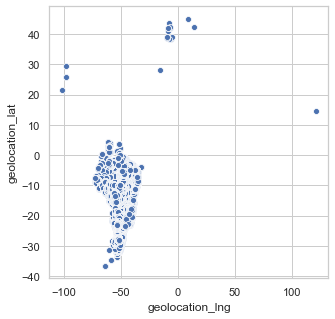

In [107]:
# afficher la répartion des localisations détaillées
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x='geolocation_lng',
                y='geolocation_lat',
                data=df_geolocation)

In [108]:
# identifier les localisations hors Brésil
cols = ['geolocation_city',
        'geolocation_state',
        'geolocation_lat',
        'geolocation_lng']
mask = (df_geolocation['geolocation_lat'] > 10)
print(df_geolocation[cols][mask].shape)
df_geolocation[cols][mask].sample(7)

(26, 4)


,geolocation_city,geolocation_state,geolocation_lat,geolocation_lng
865611,areia branca dos assis,PR,39.057629,-9.400037
727755,pau d'arco,AL,45.065933,9.341528
538557,santo antonio do canaa,ES,21.657547,-101.466766
769351,porto trombetas,PA,42.166805,-6.898531
514429,raposo,RJ,38.381672,-6.328200
769436,porto trombetas,PA,42.167251,-6.898559
697048,ibiajara,BA,38.991963,-4.947823


In [109]:
# retirer les localisations marginales
df_geolocation = df_geolocation[df_geolocation['geolocation_lat'] < 10].copy()

In [110]:
# associer des paires {lat, lng} uniques aux {city, state} uniques
# normaliser les noms de ville, et effet de la normalisation
print('geoloc cities : '
      + str(df_geolocation['geolocation_city'].unique().size))
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('geoloc cities norm : '
      + str(df_geolocation['geolocation_city'].unique().size))
print('customers cities : '
      + str(df_customers['customer_city'].unique().size))
df_customers['customer_city'] = df_customers['customer_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('customers cities norm : '
      + str(df_customers['customer_city'].unique().size))
print('sellers cities : '
      + str(df_sellers['seller_city'].unique().size))
df_sellers['seller_city'] = df_sellers['seller_city'].str\
    .normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
print('sellers cities norm : '
      + str(df_sellers['seller_city'].unique().size))
# améliorer la lisibilité en écriture type "title"
df_customers['customer_city'] = df_customers['customer_city'].str.title()
df_sellers['seller_city'] = df_sellers['seller_city'].str.title()
df_geolocation['geolocation_city'] = df_geolocation['geolocation_city'].str.title()

geoloc cities : 8007
geoloc cities norm : 5965
customers cities : 4119
customers cities norm : 4119
sellers cities : 611
sellers cities norm : 609


In [111]:
# simplifier par une latitude unique {ville, état}
df_geolocation['geolocation_lat'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lat'].transform(lambda x: x.mean())

In [112]:
# simplifier par une longitude unique {ville, état}
df_geolocation['geolocation_lng'] = df_geolocation.groupby(
    ['geolocation_city',
     'geolocation_state']
)['geolocation_lng'].transform(lambda x: x.mean())

In [113]:
# observer le résultat des traitements
df_geolocation.head(7)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.571253,-46.633911,Sao Paulo,SP
1,1046,-23.571253,-46.633911,Sao Paulo,SP
2,1046,-23.571253,-46.633911,Sao Paulo,SP
3,1041,-23.571253,-46.633911,Sao Paulo,SP
4,1035,-23.571253,-46.633911,Sao Paulo,SP
5,1012,-23.571253,-46.633911,Sao Paulo,SP
6,1047,-23.571253,-46.633911,Sao Paulo,SP


In [114]:
# conserver une seule localisation détaillée par {city, state}
print('geoloc with {city, state} duplicates shape : '
      + str(df_geolocation.shape))
df_geolocation = df_geolocation.drop_duplicates(['geolocation_city',
                                                 'geolocation_state']).copy()
print('geoloc unique {city, state} shape : '
      + str(df_geolocation.shape))

geoloc with {city, state} duplicates shape : (1000137, 5)
geoloc unique {city, state} shape : (6345, 5)


In [115]:
# aggréger la localisation unique pour customers et sellers
df_customers = df_customers.merge(
    df_geolocation,
    how='left',
    left_on=['customer_city', 'customer_state'],
    right_on=['geolocation_city', 'geolocation_state'])
df_sellers = df_sellers.merge(
    df_geolocation,
    how='left',
    left_on=['seller_city', 'seller_state'],
    right_on=['geolocation_city', 'geolocation_state'])

In [116]:
# observer le résultat pour customers
df_customers.sample(7)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_count,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
11828,732fd821e30b8a31ff30c0650239eb99,1d41d4877b1d13802db2a5cc6a7f4e64,21630,Rio De Janeiro,RJ,1,20010.0,-22.914911,-43.312877,Rio De Janeiro,RJ
53140,e3cc4bf7e43cc5afc7bfc9693dcd5938,3511aa3ff5fb9645041bf1875415142d,3523,Sao Paulo,SP,2,1037.0,-23.571253,-46.633911,Sao Paulo,SP
87984,21239b911af74450df7b0ce5b78b39d9,0d9d2172152c87b756cb2d0304c6ad51,88545,Palmeira,SC,1,88545.0,-27.573569,-50.155865,Palmeira,SC
49701,58a3dd1d3e66c3d3331eb095a93876a5,031ea691b99fc101dcad357d1a83573f,1332,Sao Paulo,SP,2,1037.0,-23.571253,-46.633911,Sao Paulo,SP
28018,000fd45d6fedae68fc6676036610f879,cee6fa72fb403ef9554b41581108084b,12970,Piracaia,SP,1,12970.0,-23.055861,-46.359236,Piracaia,SP
64393,dceab7a0356dfd73d5b0f9c14f1ce7ad,3bea625d5075352d71df6c3c074159b5,17220,Jau,SP,1,17209.0,-22.291905,-48.558376,Jau,SP
19225,d5c96d2a6e1eb3023eca2f5da25d1ad6,c9c95b219030669874730623d9f9a7a5,14030,Ribeirao Preto,SP,1,14025.0,-21.180777,-47.804403,Ribeirao Preto,SP


In [117]:
# réagencer les colonnes customers
df_customers = df_customers.rename(columns={
    'geolocation_lat': 'customer_lat',
    'geolocation_lng': 'customer_lng'})
df_customers = df_customers.drop(
    columns=['customer_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state'])

In [118]:
# réagencer les colonnes sellers (idem customers)
df_sellers = df_sellers.rename(columns={
    'geolocation_lat': 'seller_lat',
    'geolocation_lng': 'seller_lng'})
df_sellers = df_sellers.drop(
    columns=['seller_zip_code_prefix',
             'geolocation_zip_code_prefix',
             'geolocation_city',
             'geolocation_state'])

In [119]:
# observer le résultat pour sellers
df_sellers.sample(7)

,seller_id,seller_city,seller_state,seller_lat,seller_lng
580,f76a3b1349b6df1ee875d1f3fa4340f0,Sao Paulo,SP,-23.571253,-46.633911
1195,466222e777149751370e7e98fb623b0c,Rio De Janeiro,RJ,-22.914911,-43.312877
2623,1746c1ae87ac63d530c7c943d0ac42e2,Santana De Parnaiba,SP,-23.452703,-46.879829
2340,5dceca129747e92ff8ef7a997dc4f8ca,Santa Barbara D Oeste,SP,-22.749384,-47.391133
2188,b906dd0e57f282c7089171b6ed07982e,Parana,PR,NaN,NaN
679,b8578d2d823bd8e251f6fdd02b40902d,Blumenau,SC,-26.899545,-49.088593
2476,0725b8c0f3f906e58f70cbe76b7c748c,Guarulhos,SP,-23.446403,-46.498768


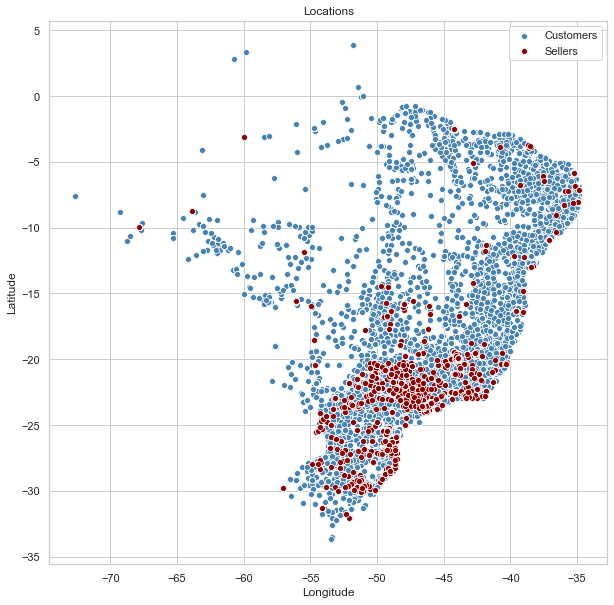

In [120]:
# affichier la nouvelle répartion (carte)
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x='customer_lng',
                y='customer_lat',
                color='steelblue',
                data=df_customers,
                label='Customers')
sns.scatterplot(x='seller_lng',
                y='seller_lat',
                color='darkred',
                data=df_sellers,
                label='Sellers')
plt.title('Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 2.1.2. Paiements

Un client peut choisir de payer à l'aide de plusieurs payment_type ce qui ouvre un payment_sequential >1. <br/> 
Il peut également choisir un étalement en n fois (valeur de payment_installments).

In [121]:
# montrer un aperçu des données de paiement
df_payments.sample(7)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
94895,e7645f2073cac65748cf53c69d5abea9,1,credit_card,1,67.50
32624,736401dfe860545394d24b098b2728eb,1,credit_card,4,46.04
18371,c300acfe1a7f3217eda136d29dad508a,1,credit_card,7,74.14
25259,04075153ea747446984b909a58edef85,1,credit_card,1,97.66
94921,481d2cbce45c1d2281aead91bff6dcae,1,credit_card,10,155.14
77058,988117e4f714ed70371d15b7063e0add,1,credit_card,8,186.13
6558,581e5298655b47d098b024c86e9239e3,1,credit_card,10,463.44


In [122]:
df_payments[df_payments['order_id'] == '1b15974a0141d54e36626dca3fdc731a']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
30258,1b15974a0141d54e36626dca3fdc731a,1,boleto,1,2202.4


In [123]:
# lister les type de paiement
df_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

Text(0.5, 1.02, 'Payment Types')

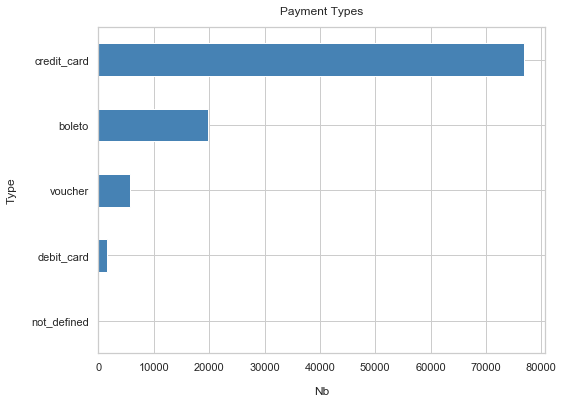

In [124]:
# observer la répartition des paiements par type
df_payments['payment_type'].value_counts().plot(
    kind='barh',
    color='steelblue',
    figsize=(8, 6)).invert_yaxis()
plt.xlabel('Nb', labelpad=14)
plt.ylabel('Type', labelpad=14)
plt.title('Payment Types', y=1.02)

In [125]:
# identifier les types non définis
cols = ['payment_sequential',
        'payment_type',
        'payment_installments',
        'payment_value']
mask = (df_payments['payment_type'] == 'not_defined')
print(df_payments[cols][mask].shape)
df_payments[cols][mask].sample(3)

(3, 4)


,payment_sequential,payment_type,payment_installments,payment_value
94427,1,not_defined,1,0.0
51280,1,not_defined,1,0.0
57411,1,not_defined,1,0.0


In [126]:
# retirer les paiements indéfinis
df_payments = df_payments[df_payments['payment_type'] != 'not_defined']
print(df_payments.shape)

(103883, 5)


Il sera intéressant de caractériser le mode de paiement privilégié de chaque client : valeur moyenne d'achat, nb de versements.

### 2.1.4. Review

In [127]:
# montrer un aperçu des review
df_reviews.sample(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
5443,3ff6c72bf600da5739ae36a7679f82c5,701497f084be73caaae3efa1dad2422a,5,NaN,Produto de excelente qualidade,2017-08-25 00:00:00,2017-08-28 12:50:20
46234,92ebd832fa678fdf3033f31507d76d24,40bc1f323f6bb2c5fb7d2cae41952a21,5,NaN,"Chegou antes do prazo, tapete lindo e ótimo \r\n",2018-01-16 00:00:00,2018-01-16 20:52:50
54084,646addeddd4d46b6750a7c5e39a6f1d0,879789a8903f3f832bf5ab0417ea3a31,3,NaN,Útil e prática para a limpeza.,2017-08-09 00:00:00,2017-08-09 23:52:25
60784,def3deaf17d0ae98cfeab1aa586be6d1,6430ecb0185bdb039eaa6b867f26a893,5,NaN,NaN,2018-04-20 00:00:00,2018-04-20 10:55:16
52462,72187ca3e933c51b9a6fe64698d51351,642b02cc49a41f1a1edfcad2d7222c3c,5,NaN,NaN,2017-02-13 00:00:00,2017-02-14 09:32:30


In [128]:
# Valoriser la longueur du titre et du commentaire aspect qualitatif

In [129]:
# Valoriser le délai de réponse

### Délai de réponse suite à une demande de review
Comportement évaluateur d'un client : délai de réponse.

In [130]:
# formater les champs date
for col in ['review_creation_date', 'review_answer_timestamp']:
    df_reviews[col] = pd.to_datetime(df_reviews[col], format='%Y-%m-%d %H:%M:%S')

In [131]:
# calculer le délai de réponse (demande d'ajout d'une review)
df_reviews['review_answer_delay'] =\
    (df_reviews['review_answer_timestamp'] - df_reviews['review_creation_date']).dt.days

In [132]:
df_reviews.sample(7)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,review_answer_delay
16744,b1cf7bd254fd99a0f3b3372122b9575a,abf1130bc676c9dcadf91e24f5e30a30,1,NaN,"Foi feita entrega parcial, falta dois suoortes...",2018-01-20,2018-01-22 22:30:22,2
20040,50b09c811df96a297bf8824830d01bc6,01ae5e4c5d2549f7c05000a2f5856c28,5,NaN,NaN,2017-11-17,2017-11-18 10:46:01,1
74485,e2fca4bdadcfd89d58891c1b6cf5f529,c3e9d9951790c4e72c7c07eb6517ac6d,5,NaN,NaN,2017-12-21,2017-12-22 11:03:20,1
66214,6c301dd23bcc0a3b7dbbbb7b708ab102,e417eb578007d00c0b658bc321e625fb,5,NaN,Produto muito bom e foi entregue bem antes do ...,2017-10-14,2017-10-15 02:01:32,1
64213,393d6ed0c01b55d81935a726ef3e1317,ec1ddc5ed60d1e3c7a4e0635c316aed3,4,NaN,NaN,2018-08-15,2018-08-21 15:18:06,6
62071,ee59823404cbc10fd1e06c1de4e4150e,88ff50ec153428aa5372c0276c7dd75f,5,NaN,Perfeitamente embalado. Sem amassou.,2017-11-08,2017-11-09 14:35:28,1
22135,880d11d1f58e0b82a36637279229eca4,8bc81ec47c8188753c5c4170dff3e36f,5,NaN,NaN,2018-04-07,2018-04-10 10:17:15,3


Il sera intéressant d'ajouter le délai moyen de réponse d'un client, la moyenne des notes données par un client, la moyenne des notes obtenues pour un produit pour caractériser le comportement d'achat.

## 2.2. Aggrégation des données

In [133]:
# aggréger les df (selon le modèle de données : à partir des "orders")
# via order_id pour les items, les payments et les reviews
df = pd.merge(df_orders, df_items, how='left', on='order_id')
df = pd.merge(df, df_payments, how='outer', on='order_id')
df = pd.merge(df, df_reviews, how='outer', on='order_id')
# via le customer_id pour les customers
df = pd.merge(df, df_customers, how='outer', on='customer_id')
# en rang 2 pour les items
# via le seller_id pour les sellers
df = pd.merge(df, df_sellers, how='outer', on='seller_id')
# via le product_id pour les products
df = pd.merge(df, df_products, how='outer', on='product_id')
# et enfin la tradiction du product_category_name
df = pd.merge(df, df_translation, how='outer', on='product_category_name')

KeyError: 'product_category_name'

In [ ]:
df.columns

In [ ]:
df.sample(5)

In [ ]:
df_customers['customer_state'].unique()

In [ ]:
df_sellers['seller_state'].unique()

In [ ]:
df.shape

In [ ]:
df.columns

## 2.3. Elaboration de nouveaux features (centrés Clients)

### Rattacher la note moyenne donnée à chaque produit
Influence possible de la note d'un produit sur le comportement client (décompte et note moyenne)

In [ ]:
# créer la note (décompte et moyenne)
df_prod_mean_score = df.groupby('product_id',
                                as_index=False).agg({'review_score': ['count',
                                                                      'mean']})
df_prod_mean_score.columns = ['product_id',
                              'count',
                              'mean']

# afficher les 10 produits les plus notés
df_prod_mean_score = df_prod_mean_score.sort_values(by='count',
                                                    ascending=False)
df_prod_mean_score[:10]

In [ ]:
# rattacher au df via le product_id
df_prod_mean_score = df_prod_mean_score.rename(columns={
    'count': 'product_review_count',
    'mean': 'product_review_mean'})
df = pd.merge(df, df_prod_mean_score, how='outer', on='product_id')

In [ ]:
df.sample(5)

### Rattacher la note moyenne donnée par chaque client
Comportement évaluateur d'un client : décompte et note moyenne.

In [ ]:
# créer la note (décompte et moyenne)
df_cust_mean_score = df.groupby('customer_unique_id',
                                as_index=False).agg({'review_score': ['count',
                                                                      'mean']})
df_cust_mean_score.columns = ['customer_unique_id',
                              'count',
                              'mean']

# afficher les 10 clients donnant les meilleurs notes
df_cust_mean_score = df_cust_mean_score.sort_values(by='count',
                                                    ascending=False)
df_cust_mean_score[:10]

In [ ]:
# rattacher au df via le customer_unique_id
df_cust_mean_score = df_cust_mean_score.rename(columns={
    'count': 'customer_review_count',
    'mean': 'customer_review_mean'})
df = pd.merge(df, df_cust_mean_score, how='outer', on='customer_unique_id')

In [ ]:
# identifier les localisations hors Brésil
mask = (df['customer_review_count'] > 24)
print(df[:][mask].shape)
df[:][mask].sample(7)

### délai de réponse

In [ ]:
# créer le délai de réponse moyen
df_cust_answer_delay = df_reviews.groupby('customer_unique_id',
                                  as_index=False).agg({'review_answer_delay': ['mean']})

### Données temporelles

In [ ]:
# formater toutes les colonnes dates
date_columns = ['shipping_limit_date',
                'order_purchase_timestamp',
                'order_approved_at',
                'order_delivered_carrier_date',
                'order_delivered_customer_date',
                'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# décomposer en année, mois, jour, heure et spécifier les jours et les mois
df['order_purchase_year'] = \
    df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = \
    df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = \
    df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = \
    df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = \
    df['order_purchase_dayofweek'].map({0: 'Mon',
                                        1: 'Tue',
                                        2: 'Wed',
                                        3: 'Thu',
                                        4: 'Fri',
                                        5: 'Sat',
                                        6: 'Sun'})
df['order_purchase_month'] = \
    df.order_purchase_timestamp.apply(lambda x: x.month).map({0: 'Jan',
                                                              1: 'Feb',
                                                              2: 'Mar',
                                                              3: 'Apr',
                                                              4: 'May',
                                                              5: 'Jun',
                                                              6: 'Jul',
                                                              7: 'Aug',
                                                              8: 'Sep',
                                                              9: 'Oct',
                                                              10: 'Nov',
                                                              11: 'Dec'})

In [ ]:
df.sample(5)